In [1]:
import numpy as np
import pandas as pd

import os
os.chdir('C:/Users/emigi/OneDrive/Desktop/Dissertation/Analysis Files/NLP Part')

In [4]:
first_trial_df = pd.read_excel('Fake News 10000 1700 Classified.xlsx')

articles_text = pd.read_excel("10000ish Articles Text.xlsx")

first_trial_df['Article Text'] = articles_text.iloc[:, 1]

In [5]:
sample_one_percent_labelled = pd.read_excel('Sample One Percent Italian Fakenews Party Labelled Naively.xlsx')

In [6]:
party = []

for text in first_trial_df['Article Text'].iloc[1786:]:
    if not isinstance(text, str):
        party.append(np.nan)
    else:
        L_count = text.count('Lega') + text.count('lega')
        M5_count = text.count('Movimento 5 stelle') + text.count('Movimento 5 Stelle') + text.count('movimento 5 stelle')
        PD_count = text.count('Partito Democratico') + text.count('partito democratico')
        FI_count = text.count('Forza Italia') + text.count('forza italia')
        if L_count > M5_count + PD_count + FI_count:
            party.append('L')
        elif M5_count > L_count + PD_count + FI_count:
            party.append('M5')
        elif FI_count > L_count + PD_count + M5_count:
            party.append('FI')
        elif PD_count > M5_count + L_count + FI_count:
            party.append('PD')
        else:
            party.append('O')
            
first_trial_df.Party.iloc[1786:] = party

## Filtering out the nan

first_trial_df = first_trial_df.dropna(subset=['Party'])

## Creating a whole dataset

frames = [first_trial_df, sample_one_percent_labelled]

final_df = pd.concat(frames)

C:\Users\emigi\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
from tqdm import tqdm
import re
import math
import operator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, merge, Masking,TimeDistributed
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

Using TensorFlow backend.


In [8]:
## Testing first iteration

glove_path = 'C:/Users/emigi/OneDrive/Desktop/Dissertation/Analysis Files/NLP Part/glove_WIKI'

glove_model = Word2Vec.load('glove_WIKI')

In [9]:
## Loading the italian word embeddings

## Create a dictionary covering all possible words in the sample

starting_train = final_df.dropna(subset=['Sentiment'])

starting_train = starting_train[starting_train['Article Text'] != 0]
starting_train = starting_train.dropna(subset=['Article Text'])
final_df = final_df[final_df['Article Text'] != 0]
final_df = final_df.dropna(subset=['Article Text'])

In [10]:
## Defining initial train and test

final_df = pd.read_excel('Final Df Advanced Italian News.xlsx')

def train_test_division(starting_train, df, division_percentage):
    n = starting_train.shape[0]
    n_test = int((n / division_percentage[0])*division_percentage[1])
    test_data = df.iloc[n:(n+n_test)+1, :]
    return (starting_train, test_data)

starting_train, starting_test = train_test_division(starting_train, final_df, (0.7, 0.3))

In [11]:
from keras import losses
from keras import metrics
  
def model_bilstm_attention(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    l = Bidirectional(LSTM(64, return_sequences=True, go_backwards=True))(x)
    g = Bidirectional(GRU(64, return_sequences=True))(x)
    x = concatenate([l, g])
    x = Bidirectional(LSTM(64//2, return_sequences=True))(x)
    
    
    # x1 = Attention(maxlen)(x)
    x2 = GlobalAveragePooling1D()(x)
    x3 = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([x2, x3])
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    outp = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def formatting_matrix_X(starting_train_df):
    
    
    ## Get the top 50 words in order of presence and get their vector
    ## Then, compute the mean of each
    word_embedding_X = np.ones(10)
    itera = 0
    for d in starting_train_df['Dictionary Words']:
        means_array = []
        sort_dict = sorted(d, key=d.get, reverse=True)
        top_10 = sort_dict[:10]      ## 10 values for each article
        for word in top_10: 
            try:
                word_vector = glove_model.wv[word]
                mean = np.mean(word_vector)
                means_array.append(mean)
                itera += 1
            except:
                pass  
        print(itera)                                
        
        if len(means_array) < 10:
            print(f'Length of means_array : {len(means_array)}')
            means_array = means_array + [np.mean(means_array)]*(10 - len(means_array))
           
        
        means_array = np.array(means_array)
        word_embedding_X = np.vstack((word_embedding_X, means_array))
    ## Dropping the first column
    formatting_matrix_X = np.delete(word_embedding_X, 0, 0)
    return formatting_matrix_X


def word_embedding(df):
    
    articles = df['Article Text']
    general_vectors_distr = []
    mem_l = []
    nb_words = 0
    iterat1 = 0
    for art in articles:
        tokens = nltk.word_tokenize(art, language='italian')
        for t in tokens:
            try:
                word_vector = glove_model.wv[t]
                general_vectors_distr.append(word_vector)
                if t in mem_l:
                    pass
                else:
                    mem_l.append(t)
                    nb_words += 1
            except:
                pass
        # print(iterat1)
        iterat1 += 1
      
    all_embs = np.stack(general_vectors_distr)  
    emb_mean, emb_std = all_embs.mean(), all_embs.std()    
    embed_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    ## filling the embedding matrix
    iterat2 = 0
    for token, i in zip(mem_l, range(nb_words)):
        embedding_matrix[i] = glove_model[token]
        # print(iterat2)
        iterat2 += 1
    
    return embedding_matrix

In [12]:
word_embedding_starting_df = word_embedding(pd.concat([starting_train, starting_test])) ## Loading Word Embeddings
# pd.DataFrame(word_embedding_starting_df).to_excel('Word Embedding Starting Dataset.xslx')
starting_train_X = starting_train['Article Text']
starting_test_X = starting_test['Article Text']
starting_train_Y = starting_train['Sentiment']
starting_test_Y = starting_test['Sentiment']

C:\Users\emigi\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [13]:
embed_size = 300 # how big is each word vector
max_features = 12022 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in an article to use

## To input into the neural network, we must first tokenize the sentences

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(starting_train_X))
train_X = tokenizer.texts_to_sequences(starting_train_X)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(starting_test_X))
test_X = tokenizer.texts_to_sequences(starting_test_X)

## Pad the sequences
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [14]:
## Converting the output shape to categoricals
from keras.utils import to_categorical

## converting the bad sentiment (i.e. -1, to 2)

starting_train_Y[starting_train_Y == -1] = 2

train_Y = to_categorical(starting_train_Y)

embedding_matrix = np.mean([word_embedding_starting_df], axis = 0)
np.shape(embedding_matrix)
model = model_bilstm_attention(embedding_matrix)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     3606600     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 128)     186880      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [15]:
## Fitting the model with 1 epoch and with dummy for 0 sentiment
## Given the initial distribution of sentiments : <200 for -1 and approx. 200 for class 1
## I will use class weight function
class_weight = {0 : 1.15,
                1 : 0.85}
class_weight_negatives = {0 : 1.,
                          1 : 2.4}
class_weight_positives = {0 : 1.,
                          1 : 1.8}

In [16]:
## Generating three different models for neutrals, positives and negatives, respectively

res_pred = model.fit(train_X, train_Y[:, 0], validation_split=0.2, epochs=20, class_weight = class_weight)
pred_test_x = model.predict(test_X)
res_pred_pos = model.fit(train_X, train_Y[:, 1], validation_split=0.2, epochs=20, class_weight = class_weight_positives)
pred_test_x_ones = model.predict(test_X)
res_pred_negatives = model.fit(train_X, train_Y[:, 2], validation_split=0.2, epochs=20, class_weight = class_weight_negatives)
pred_test_x_negatives = model.predict(test_X)

Train on 1036 samples, validate on 260 samples
Epoch 1/20
1036/1036 [==============================] - 6s 6ms/step - loss: 0.6535 - accuracy: 0.6515 - val_loss: 0.5061 - val_accuracy: 0.9654
Epoch 2/20
1036/1036 [==============================] - 4s 3ms/step - loss: 0.6517 - accuracy: 0.6496 - val_loss: 0.4897 - val_accuracy: 0.9654
Epoch 3/20
1036/1036 [==============================] - 4s 4ms/step - loss: 0.6568 - accuracy: 0.6448 - val_loss: 0.4862 - val_accuracy: 0.9654
Epoch 4/20
1036/1036 [==============================] - 4s 4ms/step - loss: 0.6502 - accuracy: 0.6506 - val_loss: 0.4462 - val_accuracy: 0.9654
Epoch 5/20
1036/1036 [==============================] - 4s 3ms/step - loss: 0.6538 - accuracy: 0.6506 - val_loss: 0.4911 - val_accuracy: 0.9654
Epoch 6/20
1036/1036 [==============================] - 4s 3ms/step - loss: 0.6485 - accuracy: 0.6506 - val_loss: 0.4933 - val_accuracy: 0.9654
Epoch 7/20
1036/1036 [==============================] - 4s 3ms/step - loss: 0.6456 - accu

Epoch 17/20
1036/1036 [==============================] - 4s 4ms/step - loss: 0.6174 - accuracy: 0.8591 - val_loss: 0.3480 - val_accuracy: 0.9885
Epoch 18/20
1036/1036 [==============================] - 4s 4ms/step - loss: 0.6174 - accuracy: 0.8591 - val_loss: 0.3723 - val_accuracy: 0.9885
Epoch 19/20
1036/1036 [==============================] - 4s 4ms/step - loss: 0.6151 - accuracy: 0.8591 - val_loss: 0.3744 - val_accuracy: 0.9885
Epoch 20/20
1036/1036 [==============================] - 4s 4ms/step - loss: 0.6048 - accuracy: 0.8591 - val_loss: 0.3907 - val_accuracy: 0.9885


In [17]:
acc_pred = res_pred.history['accuracy'][-1]
test_acc_pred = res_pred.history['val_accuracy'][-1]

acc_pos_pred = res_pred_pos.history['accuracy'][-1]
test_acc_pos_pred = res_pred_pos.history['val_accuracy'][-1]

acc_neg_pred = res_pred_negatives.history['accuracy'][-1]
test_acc_neg_pred = res_pred_negatives.history['val_accuracy'][-1]

In [18]:
## Rounding on starting_test
## Output in probabilistic form, rounding the variables if p>=0.5 to 1, opposite to 0
pred_test_X_round = np.round(pred_test_x, decimals=0)
pred_test_X_ones_round = np.round(pred_test_x_ones, decimals=0)
pred_test_X_negatives_round = np.round(pred_test_x_negatives, decimals=0)

In [19]:
## Starting the iteration for at least 40000 articles.
## From there on the remaining ones will be predicted normally

test_pred_Y = np.hstack((pred_test_X_round, pred_test_X_ones_round, pred_test_X_negatives_round))

starting_df_Y = np.vstack((train_Y, test_pred_Y))

In [20]:
## getting last_index and setting the first parameters for the iteration

last_ind = starting_test.index[-1]
iterat = 0
df_Y_i = starting_df_Y
starting_df_iterat = final_df.iloc[:last_ind+1, :]
accuracy_l = []
accuracy_ones_l = []
accuracy_negatives_l = []
validation_l = []
validation_ones_l = []
validation_negatives_l = []
n = 0

class_weight = {0 : 3.0,
                1 : 1.0}
class_weight_negatives = {0 : 1.,
                          1 : 5.0}
class_weight_positives = {0 : 1.,
                          1 : 4.5}

In [21]:
## Iteration Algorithm for the RNN

while n < 40000:
    
    starting_train_iterat, starting_test_iterat = train_test_division(starting_df_iterat, final_df, (0.7, 0.3))
    
    df_iterat = pd.concat([starting_train_iterat, starting_test_iterat])
    n = df_iterat.shape[0]
    
#    if n >= 10000:
#        print(f'Do you want to continue? ({n} articles classified)')
#        inp = input()
#        if inp == 'Y':
#            break
#        else:
#            continue
    
    try:
        word_embedding_df_i = word_embedding(pd.concat([starting_train_iterat, starting_test_iterat]))
    except:
        pass
    max_features = word_embedding_df_i.shape[0]
    
    starting_train_X_i = starting_train_iterat['Article Text']
    starting_test_X_i = starting_test_iterat['Article Text']
    
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(starting_train_X_i))
    train_X_i = tokenizer.texts_to_sequences(starting_train_X_i)

    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(starting_test_X_i))
    test_X_i = tokenizer.texts_to_sequences(starting_test_X_i)
    
    print(f'df iterat initial shape : {df_iterat.shape}')
    ## Pad the sequences
    train_X_i = pad_sequences(train_X_i, maxlen=maxlen)
    print(f'Shape Train X : {train_X_i.shape}')
    test_X_i = pad_sequences(test_X_i, maxlen=maxlen)
    print(f'Shape Test X : {test_X_i.shape}')
    print(f'Shape Y : {df_Y_i.shape}')
    
    embedding_matrix = np.mean([word_embedding_df_i], axis = 0)
    
    model = model_bilstm_attention(embedding_matrix)
    
    for i in range(3):
        if i == 0:
            res_i_ones = model.fit(train_X_i, df_Y_i[:, i], validation_split=0.2, epochs=50, class_weight = class_weight)
            
            acc_i = res_i_ones.history['accuracy'][-1]
            val_i = res_i_ones.history['val_accuracy'][-1]
            accuracy_l.append(acc_i)
            validation_l.append(val_i)
            pred_test_x_i = model.predict(test_X_i)
            pred_test_X_round_i = np.round(pred_test_x_i, decimals=0)

            
            
        elif i == 1:
            res_i_pos = model.fit(train_X_i, df_Y_i[:, i], validation_split=0.2, epochs=10, class_weight = class_weight_positives)
            
            acc_i = res_i_pos.history['accuracy'][-1]
            val_i = res_i_pos.history['val_accuracy'][-1]
            accuracy_ones_l.append(acc_i)
            validation_ones_l.append(val_i)
            pred_test_x_ones_i = model.predict(test_X_i)
            pred_test_X_ones_round_i = np.round(pred_test_x_ones_i, decimals=0)

            
        elif i == 2:
            res_i_neg = model.fit(train_X_i, df_Y_i[:, i], validation_split=0.2, epochs=10, class_weight = class_weight_negatives)
            
            acc_i = res_i_neg.history['accuracy'][-1]
            val_i = res_i_neg.history['val_accuracy'][-1]
            accuracy_negatives_l.append(acc_i)
            validation_negatives_l.append(val_i)
            pred_test_x_negatives_i = model.predict(test_X_i)
            pred_test_X_negatives_round_i = np.round(pred_test_x_negatives_i, decimals=0)
    
    print(f'prevision shape : {pred_test_X_round_i.shape}')
    print(f'prevision shape ones : {pred_test_X_ones_round_i.shape}')
    print(f'prevision shape negat : {pred_test_X_negatives_round_i.shape}')
    
    test_pred_Y_i = np.hstack((pred_test_X_round_i, pred_test_X_ones_round_i, pred_test_X_negatives_round_i))
    df_Y_i = np.vstack((starting_df_Y, test_pred_Y_i))
    
    starting_df_Y = df_Y_i
    starting_df_iterat = df_iterat
    print(f'df iterat final shape : {starting_df_iterat.shape}')
    print(f'final df Y shape : {df_Y_i.shape}')
    
    iterat += 1

C:\Users\emigi\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


df iterat initial shape : (2646, 26)
Shape Train X : (1852, 100)
Shape Test X : (794, 100)
Shape Y : (1852, 3)
Train on 1481 samples, validate on 371 samples
Epoch 1/50
1481/1481 [==============================] - 8s 5ms/step - loss: 1.1172 - accuracy: 0.3295 - val_loss: 1.2664 - val_accuracy: 0.5364
Epoch 2/50
1481/1481 [==============================] - 5s 4ms/step - loss: 1.1099 - accuracy: 0.3639 - val_loss: 1.1739 - val_accuracy: 0.5418
Epoch 3/50
1481/1481 [==============================] - 5s 4ms/step - loss: 1.1127 - accuracy: 0.3329 - val_loss: 1.2410 - val_accuracy: 0.5580
Epoch 4/50
1481/1481 [==============================] - 5s 4ms/step - loss: 1.1014 - accuracy: 0.3315 - val_loss: 1.3033 - val_accuracy: 0.5633
Epoch 5/50
1481/1481 [==============================] - 5s 4ms/step - loss: 1.0956 - accuracy: 0.3383 - val_loss: 1.2139 - val_accuracy: 0.5633
Epoch 6/50
1481/1481 [==============================] - 5s 4ms/step - loss: 1.0879 - accuracy: 0.3937 - val_loss: 1.1084 -

Epoch 40/50
2116/2116 [==============================] - 36s 17ms/step - loss: 0.9484 - accuracy: 0.6096 - val_loss: 0.8196 - val_accuracy: 0.5208
Epoch 41/50
2116/2116 [==============================] - 36s 17ms/step - loss: 0.9395 - accuracy: 0.6082 - val_loss: 0.7905 - val_accuracy: 0.5679
Epoch 42/50
2116/2116 [==============================] - 36s 17ms/step - loss: 0.9404 - accuracy: 0.6144 - val_loss: 0.8162 - val_accuracy: 0.5189
Epoch 43/50
2116/2116 [==============================] - 36s 17ms/step - loss: 0.9431 - accuracy: 0.6106 - val_loss: 0.7815 - val_accuracy: 0.5585
Epoch 44/50
2116/2116 [==============================] - 36s 17ms/step - loss: 0.9535 - accuracy: 0.5988 - val_loss: 0.7775 - val_accuracy: 0.5642
Epoch 45/50
2116/2116 [==============================] - 36s 17ms/step - loss: 0.9518 - accuracy: 0.6026 - val_loss: 0.7572 - val_accuracy: 0.5849
Epoch 46/50
2116/2116 [==============================] - 36s 17ms/step - loss: 0.9454 - accuracy: 0.6125 - val_loss: 0

4321/4321 [==============================] - 69s 16ms/step - loss: 1.0006 - accuracy: 0.5850 - val_loss: 0.7347 - val_accuracy: 0.9454
Epoch 7/50
4321/4321 [==============================] - 69s 16ms/step - loss: 0.9852 - accuracy: 0.6017 - val_loss: 0.6045 - val_accuracy: 0.9741
Epoch 8/50
4321/4321 [==============================] - 69s 16ms/step - loss: 0.9929 - accuracy: 0.5985 - val_loss: 0.9190 - val_accuracy: 0.9500
Epoch 9/50
4321/4321 [==============================] - 69s 16ms/step - loss: 0.9899 - accuracy: 0.6087 - val_loss: 0.5579 - val_accuracy: 0.9426
Epoch 10/50
4321/4321 [==============================] - 69s 16ms/step - loss: 0.9786 - accuracy: 0.6098 - val_loss: 0.6289 - val_accuracy: 0.9380
Epoch 11/50
4321/4321 [==============================] - 69s 16ms/step - loss: 0.9795 - accuracy: 0.6061 - val_loss: 0.7502 - val_accuracy: 0.9500
Epoch 12/50
4321/4321 [==============================] - 69s 16ms/step - loss: 0.9696 - accuracy: 0.6061 - val_loss: 0.6061 - val_acc

Epoch 45/50
6174/6174 [==============================] - 96s 16ms/step - loss: 0.8176 - accuracy: 0.6918 - val_loss: 0.3804 - val_accuracy: 0.9870
Epoch 46/50
6174/6174 [==============================] - 96s 16ms/step - loss: 0.8192 - accuracy: 0.6919 - val_loss: 0.4213 - val_accuracy: 0.9870
Epoch 47/50
6174/6174 [==============================] - 96s 16ms/step - loss: 0.8196 - accuracy: 0.6923 - val_loss: 0.3715 - val_accuracy: 0.9870
Epoch 48/50
6174/6174 [==============================] - 97s 16ms/step - loss: 0.8164 - accuracy: 0.6921 - val_loss: 0.3219 - val_accuracy: 0.9870
Epoch 49/50
6174/6174 [==============================] - 96s 16ms/step - loss: 0.8219 - accuracy: 0.6913 - val_loss: 0.4201 - val_accuracy: 0.9870
Epoch 50/50
6174/6174 [==============================] - 96s 16ms/step - loss: 0.8159 - accuracy: 0.6921 - val_loss: 0.4027 - val_accuracy: 0.9870
Train on 6174 samples, validate on 1544 samples
Epoch 1/10
6174/6174 [==============================] - 96s 16ms/step 

Epoch 28/50
8820/8820 [==============================] - 137s 16ms/step - loss: 0.6372 - accuracy: 0.7769 - val_loss: 0.0624 - val_accuracy: 0.9973
Epoch 29/50
8820/8820 [==============================] - 138s 16ms/step - loss: 0.6347 - accuracy: 0.7772 - val_loss: 0.0698 - val_accuracy: 0.9973
Epoch 30/50
8820/8820 [==============================] - 137s 16ms/step - loss: 0.6349 - accuracy: 0.7776 - val_loss: 0.0573 - val_accuracy: 0.9964
Epoch 31/50
8820/8820 [==============================] - 137s 16ms/step - loss: 0.6309 - accuracy: 0.7781 - val_loss: 0.0792 - val_accuracy: 0.9968
Epoch 32/50
8820/8820 [==============================] - 137s 16ms/step - loss: 0.6309 - accuracy: 0.7777 - val_loss: 0.0682 - val_accuracy: 0.9973
Epoch 33/50
8820/8820 [==============================] - 138s 16ms/step - loss: 0.6283 - accuracy: 0.7773 - val_loss: 0.0730 - val_accuracy: 0.9968
Epoch 34/50
8820/8820 [==============================] - 138s 16ms/step - loss: 0.6283 - accuracy: 0.7780 - val_

12601/12601 [==============================] - 213s 17ms/step - loss: 0.1682 - accuracy: 0.9882 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 5/10
12601/12601 [==============================] - 213s 17ms/step - loss: 0.1643 - accuracy: 0.9882 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/10
12601/12601 [==============================] - 213s 17ms/step - loss: 0.1598 - accuracy: 0.9882 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 7/10
12601/12601 [==============================] - 213s 17ms/step - loss: 0.1536 - accuracy: 0.9882 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 8/10
12601/12601 [==============================] - 213s 17ms/step - loss: 0.1518 - accuracy: 0.9882 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 9/10
12601/12601 [==============================] - 213s 17ms/step - loss: 0.1521 - accuracy: 0.9882 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 10/10
12601/12601 [==============================] - 213s 17ms/step - loss: 0.1448 - accuracy: 0.9882 - val_los

25718/25718 [==============================] - 431s 17ms/step - loss: 0.2173 - accuracy: 0.9232 - val_loss: 0.0285 - val_accuracy: 0.9953
Epoch 29/50
25718/25718 [==============================] - 431s 17ms/step - loss: 0.2183 - accuracy: 0.9237 - val_loss: 0.0396 - val_accuracy: 0.9966
Epoch 30/50
25718/25718 [==============================] - 431s 17ms/step - loss: 0.2201 - accuracy: 0.9229 - val_loss: 0.0201 - val_accuracy: 0.9964
Epoch 31/50
25718/25718 [==============================] - 431s 17ms/step - loss: 0.2174 - accuracy: 0.9233 - val_loss: 0.0272 - val_accuracy: 0.9963
Epoch 32/50
25718/25718 [==============================] - 431s 17ms/step - loss: 0.2166 - accuracy: 0.9237 - val_loss: 0.0306 - val_accuracy: 0.9964
Epoch 33/50
25718/25718 [==============================] - 431s 17ms/step - loss: 0.2177 - accuracy: 0.9241 - val_loss: 0.0260 - val_accuracy: 0.9961
Epoch 34/50
25718/25718 [==============================] - 431s 17ms/step - loss: 0.2160 - accuracy: 0.9232 - va

In [22]:
## Checking the number of iterations and adding the first to the scores

accuracy_l = [acc_pred] + accuracy_l
accuracy_ones_l = [acc_pos_pred] + accuracy_ones_l
accuracy_negatives_l = [acc_neg_pred] + accuracy_negatives_l

validation_l = [test_acc_pred] + validation_l
validation_ones_l = [test_acc_pos_pred] + validation_ones_l
validation_negatives_l = [test_acc_neg_pred] + validation_negatives_l

print(f'Number of dynamic alg. : {iterat}')

Number of dynamic alg. : 9


In [23]:
accuracy_l

[0.6525096,
 0.54760295,
 0.6167297,
 0.58895504,
 0.6137468,
 0.6920959,
 0.7789116,
 0.84421873,
 0.8905677,
 0.9236333]

In [24]:
accuracy_ones_l

[0.7915058,
 0.8501013,
 0.89508504,
 0.9265873,
 0.948623,
 0.9640428,
 0.9748299,
 0.98238236,
 0.98766804,
 0.99136794]

In [25]:
accuracy_negatives_l

[0.85907334,
 0.8993923,
 0.92958415,
 0.9507275,
 0.9655172,
 0.97586656,
 0.98310655,
 0.9881756,
 0.9917231,
 0.99420637]

In [26]:
validation_l

[0.4692307710647583,
 0.7547169923782349,
 0.5603773593902588,
 0.8309115171432495,
 0.9426456689834595,
 0.9870466589927673,
 0.9972801208496094,
 0.9917486310005188,
 0.9951121807098389,
 0.99704509973526]

In [27]:
validation_ones_l

[0.9769230484962463, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [28]:
validation_negatives_l

[0.9884615540504456, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

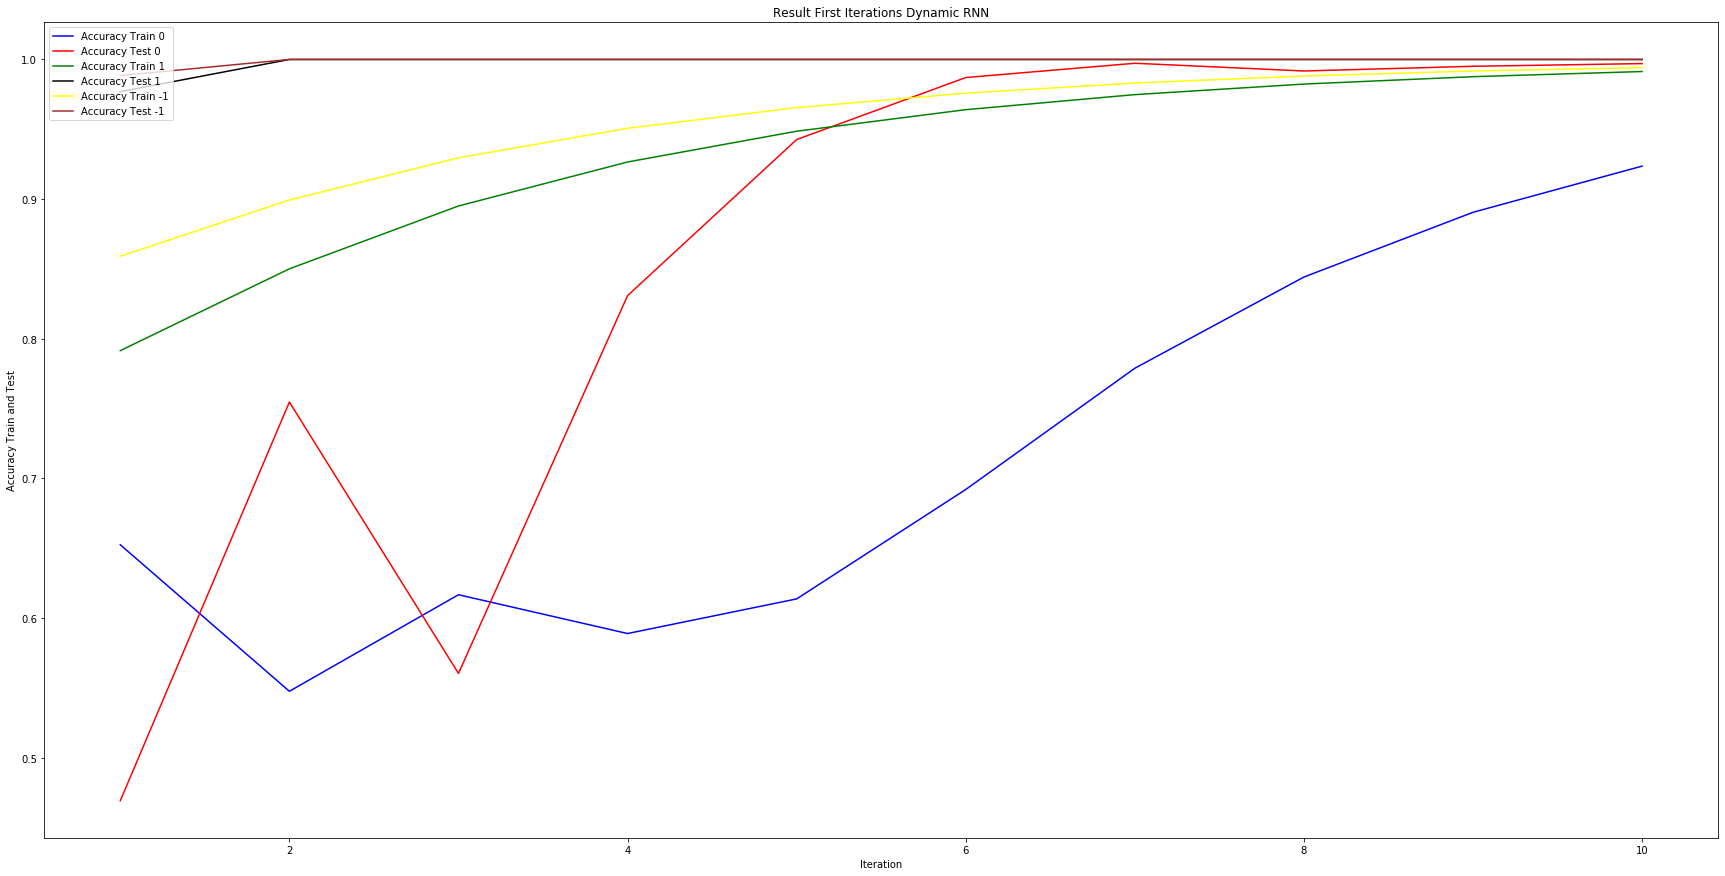

<Figure size 432x288 with 0 Axes>

In [31]:
## 8 + 1 iterations to plot. Let us plot the first 10 iterations with accuracy test, accuracy train

import matplotlib.pyplot as plt
  
iterat = list(range(1, 11))    

data = ((iterat, accuracy_l[:10]), (iterat, validation_l[:10]), (iterat, accuracy_ones_l[:10]), 
        (iterat, validation_ones_l[:10]), (iterat, accuracy_negatives_l[:10]), (iterat, validation_negatives_l[:10]))
colors = ('blue', 'red',
          'green', 'black',
          'yellow', 'brown')
groups = ('Accuracy Train 0', 'Accuracy Test 0', 'Accuracy Train 1', 'Accuracy Test 1', 'Accuracy Train -1', 'Accuracy Test -1')

fig= plt.figure(figsize=(30,15))
ax = fig.add_subplot(1, 1, 1)

for dat, color, group in zip(data, colors, groups):
    x, y = dat
    ax.plot(x, y, c=color, label=group)

plt.legend(loc=2)
plt.xlabel('Iteration')
plt.ylabel('Accuracy Train and Test')
plt.title('Result First Iterations Dynamic RNN')
plt.show()
plt.savefig('RNN Italian Articles First 9 Iterations Plot.jpeg')

In [36]:
## Converting the 46000 articles into sentiment column

sentiment = []

for y in df_Y_i:
    neutr = y[0]
    pos = y[1]
    neg = y[2]
    if neutr == 1:
        if sum([pos, neg]) < 1:
            sentiment.append(0)
        else:
            if pos == 1 and neg == 0:
                sentiment.append(1)
            elif neg == 1 and pos == 0:
                sentiment.append(-1)
            elif neg == 1 and pos == 1:
                sentiment.append(np.random.choice([-1, 1]))
    elif neutr == 0 and sum([pos, neg]) < 1:
        sentiment.append(np.random.randint(-1, 2))
    elif neutr == 0 and sum([pos, neg]) >= 1:
        if pos == 1 and neg == 0:
            sentiment.append(1)
        elif neg == 1 and pos == 0:
            sentiment.append(-1)
        elif neg == 1 and pos == 1:
                sentiment.append(np.random.choice([-1, 1]))

sentiment

[1,
 -1,
 1,
 0,
 0,
 0,
 1,
 -1,
 1,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 -1,
 -1,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 -1,
 1,
 0,
 1,
 0,
 1,
 -1,
 -1,
 1,
 -1,
 0,
 -1,
 -1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 1,
 1,
 -1,
 0,
 0,
 1,
 0,
 -1,
 0,
 -1,
 1,
 1,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 -1,
 1,
 -1,
 0,
 -1,
 -1,
 0,
 0,
 1,
 0,
 -1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 1,
 0,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 0,
 -1,
 1,
 -1,
 0,
 -1,
 1,
 1,
 0,
 1,
 0,
 -1,
 1,
 -1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 -1,
 0,
 0,
 -1,
 1,
 1,
 1,
 1,
 0,
 0,
 -1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 0,
 0,
 1,
 0,
 0,
 -1,
 1,
 -1,
 1,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 1,
 -1,
 1,
 0,
 0,

Text(0.5, 1.0, 'Final distribution of sentiment')

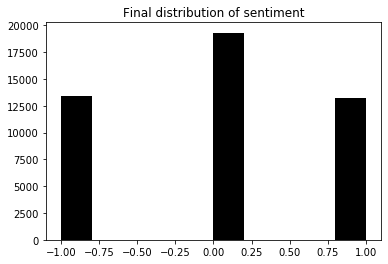

In [38]:
## plotting distribution of sentiment

plt.hist(sentiment, color='black')
plt.title('Final distribution of sentiment')

In [40]:
## including the variable in the dataset

final_df['Sentiment'].iloc[:len(sentiment)] = sentiment

final_df['Sentiment']

0        1.0
1       -1.0
2        1.0
3        0.0
4        0.0
        ... 
54665    NaN
54666    NaN
54667    NaN
54668    NaN
54669    NaN
Name: Sentiment, Length: 54670, dtype: float64

In [42]:
## Removing Nan and saving the file

final_df = final_df.dropna(subset=['Sentiment'])

final_df.to_excel('Final Dataset Italian Articles Classified.xlsx')